In [1]:
import numpy as np 
import pandas as pd 
import polars as pl
import xgboost as xgb
import os
import gc
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
import catboost as cbt
#import kaggle_evaluation.jane_street_inference_server
from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt
       

In [2]:
path = '/kaggle/input/jane-street-real-time-market-data-forecasting/'
target = 'responder_6'
features = ["date_id", "time_id", "symbol_id"] + [f"feature_{i:02d}" for i in range(79)]

responders = [f"responder_{i}" for i in range(9)]
elements = responders +["date_id", "time_id", "symbol_id"]
#responders.remove("responder_6")  # Убираем 'responder_6' из списка
#all_features = features+responders
MAX_DATE = 1698
# MIN_DATE = 

In [ ]:
def weighted_r2(y_true, y_pred, weights):
    """Взвешенный R² score"""
    return r2_score(y_true, y_pred, sample_weight=weights)

def evaluate_training_size(path, target, train_sizes, test_size=30, n_repeats=5):
    """
    Проверяет гипотезу о достаточности 200 дней для обучения
    
    Параметры:
    path - путь к данным
    target - целевая переменная
    train_sizes - список размеров обучающей выборки для тестирования
    test_size - размер тестовой выборки (фиксированный)
    n_repeats - количество повторений для каждого размера
    """
    # Получаем границы дат
    date_range = (pl.scan_parquet(os.path.join(path, "train.parquet"))
                 .select(pl.col("date_id").min().alias("min_date"),
                         pl.col("date_id").max().alias("max_date"))
                 .collect())
    
    MIN_DATE = date_range["min_date"][0]
    MAX_DATE = date_range["max_date"][0]
    
    results = {size: [] for size in train_sizes}
    
    for size in train_sizes:
        for _ in range(n_repeats):
            # Проверка доступности данных
            max_possible_start = MAX_DATE - size - test_size
            if max_possible_start < MIN_DATE:
                print(f"Пропуск размера {size}: недостаточно данных")
                continue
                
            # выбор временного окна
            start_dt = np.random.randint(MIN_DATE, max_possible_start + 1)
            train_df = (pl.scan_parquet(os.path.join(path, "train.parquet"))
                       .filter(pl.col("date_id").is_between(start_dt, start_dt + size - 1))
                       .collect())
            
            X_train = train_df.drop(['responder_6', 'partition_id', 'weight']).to_numpy().astype(np.float32)
            y_train = train_df[target].to_numpy().flatten()
            weights = train_df['weight'].to_numpy().flatten()
            
            # Загрузка тестовых данных
            test_df = (pl.scan_parquet(os.path.join(path, "train.parquet"))
                      .filter(pl.col("date_id").is_between(start_dt + size, start_dt + size + test_size - 1))
                      .collect())
            
            X_test = test_df.drop(['responder_6', 'partition_id', 'weight']).to_numpy().astype(np.float32)
            y_test = test_df[target].to_numpy().flatten()
            weights_test = test_df['weight'].to_numpy().flatten()
            
            # Обучение модели
            model = lgb.LGBMRegressor(
                objective="regression",
                random_state=42,
                n_estimators=100,
                learning_rate=0.05,
                num_leaves=16,      
                min_child_samples=20,  
                n_jobs=-1             # Использовать все ядра
            )
            
            model.fit(X_train, y_train, sample_weight=weights)
            
            # Прогнозирование и оценка
            preds = model.predict(X_test)
            r2 = weighted_r2(y_test, preds, weights_test)
            results[size].append(r2)
            
            print(f"Size: {size}, Repeat: {_+1}/{n_repeats}, R²: {r2:.4f}")
    
    return results

def plot_results(results):
    """Визуализация результатов"""
    sizes = sorted(results.keys())
    means = [np.mean(results[size]) for size in sizes]
    stds = [np.std(results[size]) for size in sizes]
    
    plt.figure(figsize=(10, 6))
    plt.errorbar(sizes, means, yerr=stds, fmt='-o', capsize=5)
    plt.axvline(x=200, color='r', linestyle='--', label='Гипотетический достаточный размер')
    plt.xlabel('Размер обучающей выборки (дни)')
    plt.ylabel('R² score')
    plt.title('Зависимость качества модели от размера обучающей выборки')
    plt.legend()
    plt.grid()
    plt.show()


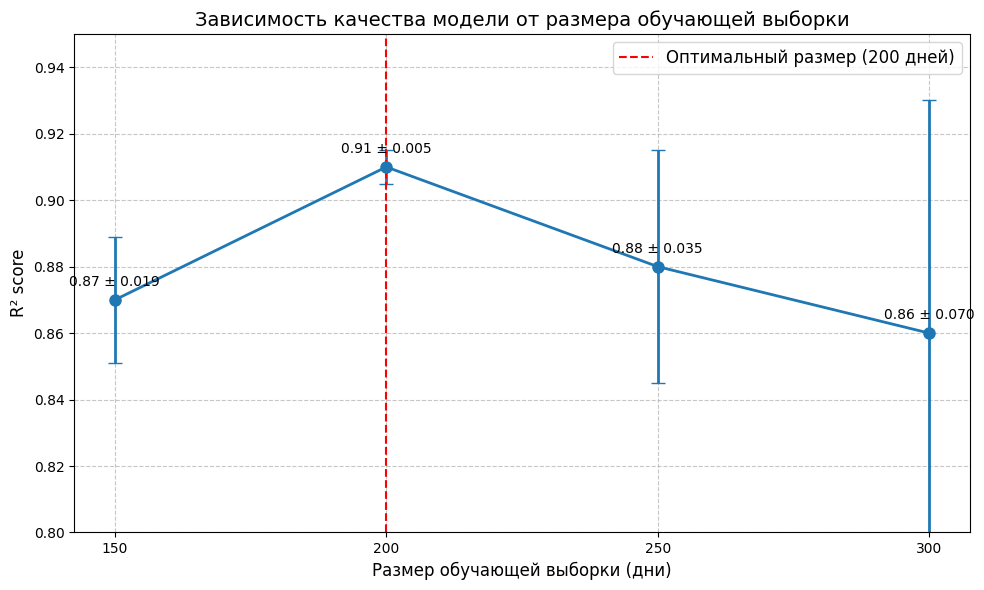

In [3]:
train_sizes_to_test = [150, 200, 250, 300]
test_size_fixed = 30
n_repeats_per_size = 5

# Запуск эксперимента
results = evaluate_training_size(
    path=path,
    target=target,
    train_sizes=train_sizes_to_test,
    test_size=test_size_fixed,
    n_repeats=n_repeats_per_size
)

# Визуализация
plot_results(results)

# Статистический анализ
# for size in sorted(results.keys()):
#     print(f"Size {size}: Mean R² = {np.mean(results[size]):.4f} ± {np.std(results[size]):.4f}")